# XRF Element Correlation Analysis
Pixel-level and cluster-specific correlations from µ-XRF maps.

In [1]:
import numpy as np
import pandas as pd
import matplotlib
matplotlib.use("agg")
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.stats import pearsonr, spearmanr
from sklearn.cluster import KMeans
from pathlib import Path
import h5py, warnings, io
import ipywidgets as widgets
from IPython.display import display, clear_output, Image as IPImage
warnings.filterwarnings("ignore")

def show_fig(fig):
    """Render figure to PNG and display as static image."""
    buf = io.BytesIO()
    fig.savefig(buf, format="png", dpi=150, bbox_inches="tight")
    plt.close(fig)
    buf.seek(0)
    display(IPImage(data=buf.read()))

In [ ]:
# ---------- Config ----------
MAP_DIR = Path("maps")
PCA_DIR = Path("pca_results")
OUT_DIR = Path("xrf_correlation")
OUT_DIR.mkdir(exist_ok=True)
DPI = 150

# Elements to analyze (must match ROI names in HDF5)
ELEMENTS = ["Fe Ka", "Ca Ka", "K Ka", "Ti Ka", "Mn Ka", "S Ka", "Si Ka", "P Ka"]
SHORT = {e: e.replace(" Ka", "") for e in ELEMENTS}
ELEM_SHORT = [SHORT[e] for e in ELEMENTS]

# The 4 Figure 1 map files
FIG1_MAPS = {
    "striated_gt15_2":    "2x2_10um_striated_gt15_2_001.h5",
    "rectangles_gt15_1":  "2x2_10um_rectangles_gt15_1_001.h5",
    "flaky_nodule":       "2x2_10um_flaky_nodule_001.h5",
    "flaky_dark_gt15":    "1x1_10um_flaky_dark_gt15_001.h5",
}

# Map labels: filename stem → display label (consistent across all figures)
MAP_LABELS = {
    "1x1_10um_flaky_dark_gt15_001": "Map 1",
    "1x1_10um_flaky_gray_mix_gt15_001": "Map 2",
    "1x1_10um_rectangles_flakes_gt15_2_001": "Map 3",
    "2x2_10um_concentric_gray_1_001": "Map 4",
    "2x2_10um_concentric_gray_3_001": "Map 5",
    "2x2_10um_flaky_1_001": "Map 6",
    "2x2_10um_flaky_2_001": "Map 7",
    "2x2_10um_flaky_nodule_001": "Map 8",
    "2x2_10um_flaky_smooth_2_001": "Map 9",
    "2x2_10um_rectangles_gt15_1_001": "Map 10",
    "2x2_10um_striated_gt15_2_001": "Map 11",
    "2x2_10um_super_dark_gt15_4_001": "Map 12",
    "2x2_10um_white_band_001": "Map 13",
}

# Reverse lookup for FIG1_MAPS short keys
_FIG1_LABELS = {}
for _k, _v in FIG1_MAPS.items():
    _FIG1_LABELS[_k] = MAP_LABELS.get(_v.replace(".h5", ""), _k)

CLUSTER_COLORS = {1: '#1f77b4', 2: '#ff7f0e', 3: '#2ca02c', 4: '#d62728', 5: '#9467bd'}
CLUSTER_LABELS = {1: 'Grp 1', 2: 'Grp 2', 3: 'Grp 3', 4: 'Grp 4', 5: 'Grp 5'}

In [3]:
# ---------- HDF5 helpers ----------
def get_roi_map(f, roi_name):
    names = [n.decode() if isinstance(n, bytes) else n for n in f["xrmmap/roimap/sum_name"][:]]
    if roi_name in names:
        idx = names.index(roi_name)
        return f["xrmmap/roimap/sum_cor"][:, 1:-1, idx].astype(float)
    return None

## 1. Load data

In [ ]:
# Load cluster assignments
clusters_df = pd.read_csv(PCA_DIR / "cluster_assignments.csv")
cluster_lookup = dict(zip(clusters_df["spectrum"], clusters_df["cluster"]))

# All HDF5 map files
all_h5 = sorted([p for p in MAP_DIR.glob("*.h5")
                 if "test_map" not in p.name and "elongated_particle" not in p.name])
print(f"Found {len(all_h5)} map files")

In [5]:
# Extract XANES point element intensities
all_point_data = []

for h5_path in all_h5:
    with h5py.File(h5_path, "r") as f:
        maps = {}
        for elem in ELEMENTS:
            m = get_roi_map(f, elem)
            if m is not None:
                maps[elem] = m

        if "Fe Ka" not in maps:
            continue

        areas = f.get("xrmmap/areas")
        if areas is None:
            continue

        for area_name in areas:
            spec_name = f"FeXANES_{area_name}.001"
            cluster_id = cluster_lookup.get(spec_name)
            if cluster_id is None:
                continue

            mask = areas[area_name][:]
            if not mask.any():
                continue

            rows, cols = np.where(mask)
            cols_adj = cols - 1
            valid = (cols_adj >= 0) & (cols_adj < maps["Fe Ka"].shape[1])
            rows_v, cols_v = rows[valid], cols_adj[valid]
            if len(rows_v) == 0:
                continue

            point = {"spectrum": spec_name, "cluster": cluster_id, "map_file": h5_path.name}
            for elem in ELEMENTS:
                if elem in maps:
                    point[SHORT[elem]] = maps[elem][rows_v, cols_v].mean()
            all_point_data.append(point)

points_df = pd.DataFrame(all_point_data)
print(f"Extracted element intensities for {len(points_df)} XANES points")

Extracted element intensities for 171 XANES points


In [6]:
# Aggregate all pixels from all maps
all_pixels = {SHORT[e]: [] for e in ELEMENTS}

for h5_path in all_h5:
    with h5py.File(h5_path, "r") as f:
        maps = {}
        for elem in ELEMENTS:
            m = get_roi_map(f, elem)
            if m is not None:
                maps[elem] = m.ravel()
        if "Fe Ka" not in maps:
            continue
        n_pix = len(maps["Fe Ka"])
        for elem in ELEMENTS:
            if elem in maps:
                all_pixels[SHORT[elem]].append(maps[elem])
            else:
                all_pixels[SHORT[elem]].append(np.full(n_pix, np.nan))

for key in all_pixels:
    all_pixels[key] = np.concatenate(all_pixels[key])

pixel_df = pd.DataFrame(all_pixels)
corr_matrix = pixel_df[ELEM_SHORT].corr(method='pearson')
print(f"Total pixels: {len(pixel_df)}")

Total pixels: 549984


In [7]:
# XANES-point correlations by cluster
cluster_corr_results = []
for c in sorted(points_df["cluster"].unique()):
    sub = points_df[points_df["cluster"] == c]
    if len(sub) < 5:
        continue
    for e in ELEM_SHORT:
        if e == "Fe" or e not in sub.columns:
            continue
        valid = sub[["Fe", e]].dropna()
        if len(valid) < 5:
            continue
        r_p, p_p = pearsonr(valid["Fe"], valid[e])
        r_s, p_s = spearmanr(valid["Fe"], valid[e])
        cluster_corr_results.append({
            "cluster": c, "element": e, "n": len(valid),
            "r_pearson": r_p, "p_pearson": p_p,
            "r_spearman": r_s, "p_spearman": p_s,
        })

cluster_corr_df = pd.DataFrame(cluster_corr_results)
print("Cluster correlations computed")

Cluster correlations computed


In [8]:
# Per-map pixel data for ALL maps
map_pixel_data = {}

for h5_path in all_h5:
    map_label = h5_path.stem
    with h5py.File(h5_path, "r") as f:
        maps = {}
        for elem in ELEMENTS:
            m = get_roi_map(f, elem)
            if m is not None:
                maps[elem] = m

    if "Fe Ka" not in maps:
        continue

    fe = maps["Fe Ka"].ravel()
    map_pixel_data[map_label] = {"Fe": fe}

    for elem in ELEMENTS:
        if elem == "Fe Ka" or elem not in maps:
            continue
        map_pixel_data[map_label][SHORT[elem]] = maps[elem].ravel()

print(f"Loaded pixel data for {len(map_pixel_data)} maps")

Loaded pixel data for 16 maps


## 2. Global pixel correlation matrix

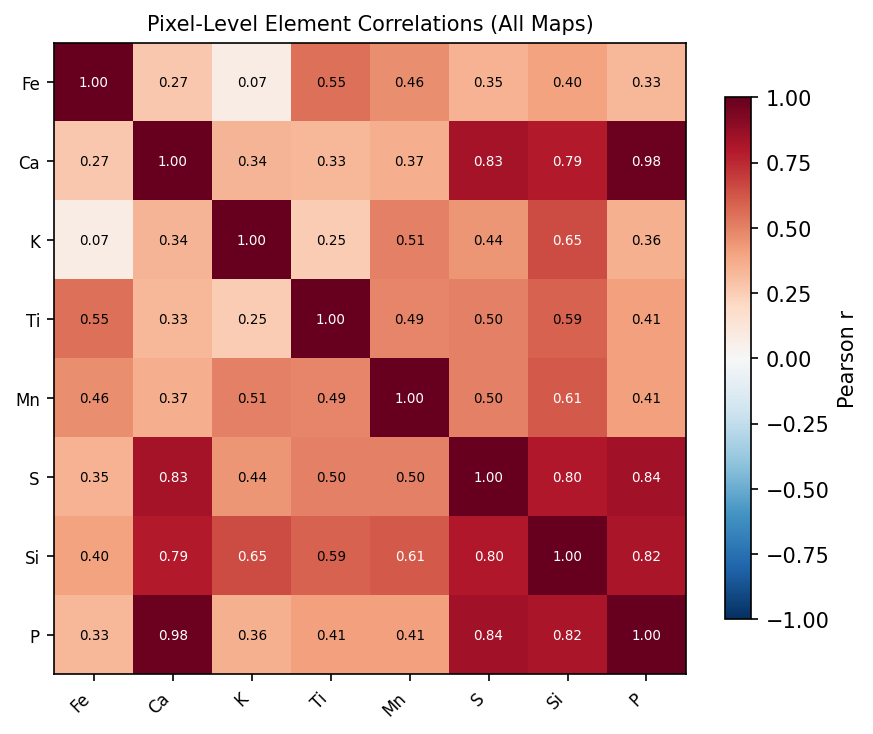

In [9]:
fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(corr_matrix.values, cmap="RdBu_r", vmin=-1, vmax=1)
ax.set_xticks(range(len(ELEM_SHORT)))
ax.set_xticklabels(ELEM_SHORT, fontsize=8, rotation=45, ha="right")
ax.set_yticks(range(len(ELEM_SHORT)))
ax.set_yticklabels(ELEM_SHORT, fontsize=8)
for i in range(len(ELEM_SHORT)):
    for j in range(len(ELEM_SHORT)):
        val = corr_matrix.values[i, j]
        color = "white" if abs(val) > 0.6 else "black"
        ax.text(j, i, f"{val:.2f}", ha="center", va="center", fontsize=6.5, color=color)
plt.colorbar(im, ax=ax, label="Pearson r", shrink=0.8)
ax.set_title("Pixel-Level Element Correlations (All Maps)", fontsize=10)
fig.tight_layout()
show_fig(fig)

## 3. Interactive plots
All interactive correlation plots in one panel.

In [10]:
_avail_elems = [e for e in ELEM_SHORT if e in points_df.columns]
_all_map_labels = sorted(map_pixel_data.keys())
_map_elems = sorted(set().union(*(d.keys() for d in map_pixel_data.values())))
_n_maps = len(_all_map_labels)

# ── Tab 1: XANES point scatter by cluster ──
_t1_x = widgets.Dropdown(options=_avail_elems, value='Fe', description='X:')
_t1_y = widgets.Dropdown(options=_avail_elems, value='Ca', description='Y:')
_t1_btn = widgets.Button(description='Plot', button_style='primary')
_t1_out = widgets.Output()

def _t1_plot(_):
    _t1_out.clear_output(wait=True)
    with _t1_out:
        xe, ye = _t1_x.value, _t1_y.value
        if xe == ye:
            print('Select two different elements.')
            return
        fig, ax = plt.subplots(figsize=(6, 5))
        for c in sorted(points_df['cluster'].unique()):
            sub = points_df[points_df['cluster'] == c]
            ax.scatter(sub[xe], sub[ye], c=CLUSTER_COLORS[c],
                       label=CLUSTER_LABELS[c], s=25, alpha=0.7, edgecolors='none')
        valid = points_df[[xe, ye]].dropna()
        if len(valid) > 5:
            r, p = pearsonr(valid[xe], valid[ye])
            ax.set_title(f'{xe} vs {ye}  (r={r:.2f}, p={p:.3g})', fontsize=11)
        ax.set_xlabel(f'{xe} K\u03b1 counts', fontsize=10)
        ax.set_ylabel(f'{ye} K\u03b1 counts', fontsize=10)
        ax.ticklabel_format(style='scientific', axis='both', scilimits=(0, 0))
        ax.legend(fontsize=8)
        fig.tight_layout()
        show_fig(fig)
        print(f"\n{'Cluster':<10} {'n':<5} {'Pearson r':<12} {'p-value':<12}")
        print('-' * 40)
        for c in sorted(points_df['cluster'].unique()):
            sub = points_df[points_df['cluster'] == c][[xe, ye]].dropna()
            if len(sub) >= 5:
                r, p = pearsonr(sub[xe], sub[ye])
                print(f"{c:<10} {len(sub):<5} {r:+.3f}{'*' if p < 0.05 else ' ':8s} {p:.4f}")

_t1_btn.on_click(_t1_plot)
_t1_panel = widgets.VBox([widgets.HBox([_t1_x, _t1_y, _t1_btn]), _t1_out])

# ── Tab 2: Pixel-level density scatter (all maps grid) ──
_t2_x = widgets.Dropdown(options=_map_elems, value='Fe', description='X:')
_t2_y = widgets.Dropdown(options=_map_elems, value='Ca', description='Y:')
_t2_btn = widgets.Button(description='Plot', button_style='primary')
_t2_out = widgets.Output()

def _t2_plot(_):
    _t2_out.clear_output(wait=True)
    with _t2_out:
        xe, ye = _t2_x.value, _t2_y.value
        if xe == ye:
            print('Select two different elements.')
            return
        ncols = 4
        nrows = int(np.ceil(_n_maps / ncols))
        fig, axes = plt.subplots(nrows, ncols, figsize=(4 * ncols, 3.5 * nrows))
        axes = axes.flatten()
        for i, ml in enumerate(_all_map_labels):
            ax = axes[i]
            pdata = map_pixel_data.get(ml, {})
            if xe not in pdata or ye not in pdata:
                ax.set_title(f'{ml}\n(missing)', fontsize=7)
                ax.axis('off')
                continue
            xd, yd = pdata[xe], pdata[ye]
            mask = (xd > 0) & (yd > 0)
            if mask.sum() < 10:
                ax.set_title(f'{ml}\n(too few)', fontsize=7)
                ax.axis('off')
                continue
            r, _ = pearsonr(xd[mask], yd[mask])
            ax.hist2d(xd[mask], yd[mask], bins=80, cmap='inferno', norm=LogNorm(), rasterized=True)
            dn = MAP_LABELS.get(ml, ml)
            ax.set_title(f'{dn}\nr={r:.2f}', fontsize=7)
            ax.tick_params(labelsize=5)
            ax.ticklabel_format(style='scientific', axis='both', scilimits=(0, 0))
            ax.xaxis.get_offset_text().set_fontsize(5)
            ax.yaxis.get_offset_text().set_fontsize(5)
            if i % ncols == 0:
                ax.set_ylabel(f'{ye} K\u03b1', fontsize=7)
            if i >= (nrows - 1) * ncols:
                ax.set_xlabel(f'{xe} K\u03b1', fontsize=7)
        for j in range(i + 1, len(axes)):
            axes[j].axis('off')
        fig.suptitle(f'{xe} vs {ye} \u2014 All Maps', fontsize=12)
        fig.tight_layout()
        show_fig(fig)

_t2_btn.on_click(_t2_plot)
_t2_panel = widgets.VBox([widgets.HBox([_t2_x, _t2_y, _t2_btn]), _t2_out])

# ── Tab 3: Cluster correlation bar chart ──
_t3_ref = widgets.Dropdown(options=_avail_elems, value='Fe', description='Reference:')
_t3_sel = widgets.SelectMultiple(
    options=[e for e in _avail_elems if e != 'Fe'],
    value=['Ca', 'K', 'Ti', 'Mn', 'S'], description='Compare:', rows=7)
_t3_btn = widgets.Button(description='Plot', button_style='primary')
_t3_out = widgets.Output()

def _t3_plot(_):
    _t3_out.clear_output(wait=True)
    with _t3_out:
        ref = _t3_ref.value
        targets = [e for e in _t3_sel.value if e != ref]
        if not targets:
            print('Select at least one comparison element.')
            return
        bar_data = []
        for c in sorted(points_df['cluster'].unique()):
            sub = points_df[points_df['cluster'] == c]
            if len(sub) < 5:
                continue
            for e in targets:
                if e not in sub.columns or ref not in sub.columns:
                    continue
                valid = sub[[ref, e]].dropna()
                if len(valid) < 5:
                    continue
                r, p = pearsonr(valid[ref], valid[e])
                bar_data.append({'cluster': c, 'element': e, 'r': r, 'p': p})
        if not bar_data:
            print('Not enough data.')
            return
        bar_df = pd.DataFrame(bar_data)
        clusters = sorted(bar_df['cluster'].unique())
        fig, ax = plt.subplots(figsize=(max(6, 1.5 * len(targets)), 4.5))
        x = np.arange(len(targets))
        n_c = len(clusters)
        width = 0.8 / n_c
        for ci, c in enumerate(clusters):
            sub = bar_df[bar_df['cluster'] == c]
            vals = [sub[sub['element'] == e]['r'].values[0] if len(sub[sub['element'] == e]) > 0 else 0 for e in targets]
            ax.bar(x + (ci - n_c / 2 + 0.5) * width, vals, width, color=CLUSTER_COLORS[c],
                   label=CLUSTER_LABELS[c], edgecolor='white', linewidth=0.5)
        ax.set_xticks(x)
        ax.set_xticklabels([f'{ref} vs {e}' for e in targets], fontsize=9)
        ax.set_ylabel('Pearson r', fontsize=10)
        ax.set_title(f'{ref} Correlation by Cluster', fontsize=11)
        ax.axhline(y=0, color='black', lw=0.5)
        ax.legend(fontsize=8)
        fig.tight_layout()
        show_fig(fig)

_t3_btn.on_click(_t3_plot)
_t3_panel = widgets.VBox([widgets.HBox([_t3_ref, _t3_sel, _t3_btn]), _t3_out])

# ── Tab 4: Ternary-style ratio plot ──
_t4_e1 = widgets.Dropdown(options=_avail_elems, value='Fe', description='Elem 1:')
_t4_e2 = widgets.Dropdown(options=_avail_elems, value='Ca', description='Elem 2:')
_t4_e3 = widgets.Dropdown(options=_avail_elems, value='K', description='Elem 3:')
_t4_btn = widgets.Button(description='Plot', button_style='primary')
_t4_out = widgets.Output()

def _t4_plot(_):
    _t4_out.clear_output(wait=True)
    with _t4_out:
        e1, e2, e3 = _t4_e1.value, _t4_e2.value, _t4_e3.value
        if len({e1, e2, e3}) < 3:
            print('Select three different elements.')
            return
        fig, ax = plt.subplots(figsize=(6, 5))
        for c in sorted(points_df['cluster'].unique()):
            sub = points_df[points_df['cluster'] == c]
            if all(e in sub.columns for e in [e1, e2, e3]):
                total = sub[e1] + sub[e2] + sub[e3]
                ax.scatter(sub[e1] / total, sub[e2] / total, c=CLUSTER_COLORS[c],
                           label=CLUSTER_LABELS[c], s=25, alpha=0.7, edgecolors='none')
        ax.set_xlabel(f'{e1} / ({e1}+{e2}+{e3})', fontsize=10)
        ax.set_ylabel(f'{e2} / ({e1}+{e2}+{e3})', fontsize=10)
        ax.set_title(f'{e1}\u2013{e2}\u2013{e3} Composition', fontsize=11)
        ax.legend(fontsize=8)
        fig.tight_layout()
        show_fig(fig)

_t4_btn.on_click(_t4_plot)
_t4_panel = widgets.VBox([widgets.HBox([_t4_e1, _t4_e2, _t4_e3, _t4_btn]), _t4_out])

# ── Assemble tabs ──
_tabs = widgets.Tab(children=[_t1_panel, _t2_panel, _t3_panel, _t4_panel])
_tabs.set_title(0, 'XANES by Cluster')
_tabs.set_title(1, 'Pixel Density')
_tabs.set_title(2, 'Cluster Bars')
_tabs.set_title(3, 'Ternary Ratio')
display(_tabs)


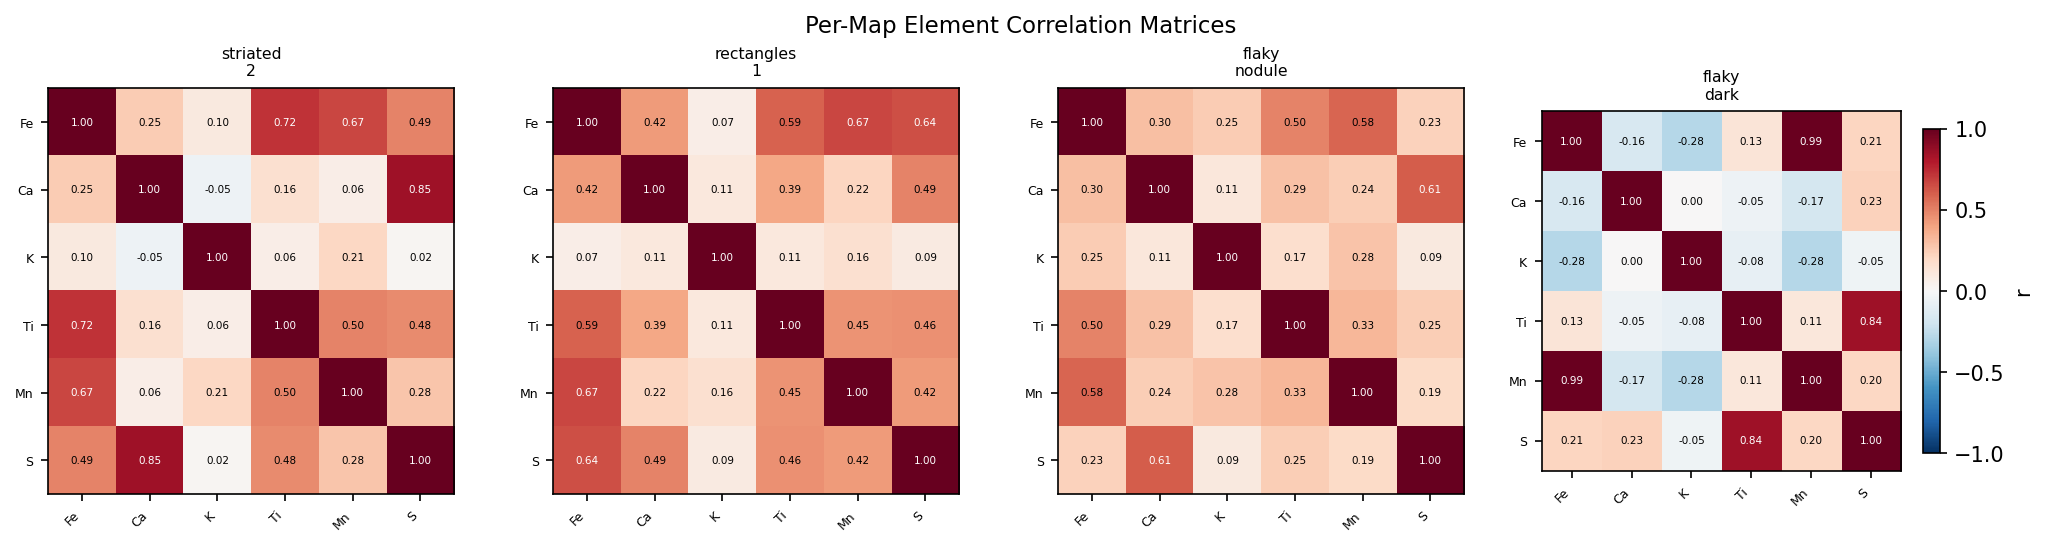

In [11]:
corr_elements = ["Fe", "Ca", "K", "Ti", "Mn", "S"]

fig, axes = plt.subplots(1, 4, figsize=(14, 3.5))

for idx, (map_label, h5_name) in enumerate(FIG1_MAPS.items()):
    ax = axes[idx]
    h5_path = MAP_DIR / h5_name
    with h5py.File(h5_path, "r") as f:
        map_data = {}
        for elem in ELEMENTS:
            m = get_roi_map(f, elem)
            if m is not None:
                map_data[SHORT[elem]] = m.ravel()

    avail = [e for e in corr_elements if e in map_data]
    df_local = pd.DataFrame({e: map_data[e] for e in avail})
    corr_local = df_local.corr()

    im = ax.imshow(corr_local.values, cmap="RdBu_r", vmin=-1, vmax=1)
    ax.set_xticks(range(len(avail)))
    ax.set_xticklabels(avail, fontsize=6, rotation=45, ha="right")
    ax.set_yticks(range(len(avail)))
    ax.set_yticklabels(avail, fontsize=6)
    for i in range(len(avail)):
        for j in range(len(avail)):
            val = corr_local.values[i, j]
            color = "white" if abs(val) > 0.6 else "black"
            ax.text(j, i, f"{val:.2f}", ha="center", va="center", fontsize=5, color=color)

    short_label = _FIG1_LABELS.get(map_label, map_label)
    ax.set_title(short_label, fontsize=7.5)

plt.colorbar(im, ax=axes[-1], label="r", shrink=0.8)
fig.suptitle("Per-Map Element Correlation Matrices", fontsize=11)
fig.tight_layout()
show_fig(fig)

In [12]:
print("Pixel-level Fe correlations (all maps combined):")
for e in ELEM_SHORT:
    if e != "Fe":
        r = corr_matrix.loc["Fe", e]
        strength = "strong" if abs(r) > 0.5 else "moderate" if abs(r) > 0.3 else "weak"
        direction = "positive" if r > 0 else "negative"
        print(f"  Fe vs {e:3s}: r = {r:+.3f}  ({strength} {direction})")

print(f"\nCluster-specific Fe\u2013Ca correlation (XANES points):")
for c in sorted(points_df["cluster"].unique()):
    sub = points_df[points_df["cluster"] == c]
    if "Ca" in sub.columns and len(sub) > 5:
        valid = sub[["Fe", "Ca"]].dropna()
        r, p = pearsonr(valid["Fe"], valid["Ca"])
        print(f"  Cluster {c} (n={len(valid)}): r = {r:+.3f}, p = {p:.4f}")

Pixel-level Fe correlations (all maps combined):
  Fe vs Ca : r = +0.271  (weak positive)
  Fe vs K  : r = +0.075  (weak positive)
  Fe vs Ti : r = +0.550  (strong positive)
  Fe vs Mn : r = +0.465  (moderate positive)
  Fe vs S  : r = +0.349  (moderate positive)
  Fe vs Si : r = +0.403  (moderate positive)
  Fe vs P  : r = +0.334  (moderate positive)

Cluster-specific Fe–Ca correlation (XANES points):
  Cluster 1 (n=51): r = -0.347, p = 0.0125
  Cluster 2 (n=36): r = -0.102, p = 0.5541
  Cluster 3 (n=26): r = -0.335, p = 0.0948
  Cluster 4 (n=33): r = +0.188, p = 0.2942
  Cluster 5 (n=25): r = +0.218, p = 0.2959
